In [48]:
import sys
import os
import json
import glob
import h5py
import time
import pdb
import functools
import multiprocessing
import numpy as np
import scipy.signal
import scipy.io.wavfile
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd


import importlib

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model
importlib.reload(bez2018model)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
importlib.reload(util_figures)
import util_stimuli
importlib.reload(util_stimuli)
import util_misc
importlib.reload(util_misc)

save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'


In [63]:
def adaptive_threshold_measurement(f0,
                                   t,
                                   sr=100e3,
                                   dBSPL_max=100.0,
                                   dBSPL_step=2.5,
                                   kwargs_nervegram={}):
    '''
    '''
    dBSPL = dBSPL_max
    list_meanrate = []
    list_dBSPL = []
    while True:
        y = np.sin(2 * np.pi * f0 * t + (np.pi/2 * np.random.rand()))
        y = util_stimuli.set_dBSPL(y, dBSPL)
        out_dict = bez2018model.nervegram(y, sr, **kwargs_nervegram)
        list_meanrate.append(np.mean(np.squeeze(out_dict['nervegram_meanrates'])))
        list_dBSPL.append(dBSPL)
        if list_meanrate[-1] > kwargs_nervegram.get('spont', 70.0) * 1.1:
            dBSPL -= dBSPL_step
        else:
            break
    return dBSPL


def get_ANF_tuning(cf,
                   kwargs_nervegram_update={},
                   list_f0=np.exp(np.linspace(np.log(1e2), np.log(1e4), 100)),
                   max_processes=60,
                   sr=100e3,
                   dBSPL_max=100.0,
                   dBSPL_step=2.5):
    '''
    '''
    kwargs_nervegram = {
        'nervegram_dur': 0.050,
        'nervegram_fs': 20e3,
        'buffer_start_dur': 0.070,
        'buffer_end_dur': 0.010,
        'pin_fs': 100e3,
        'pin_dBSPL_flag': 0,
        'pin_dBSPL': None,
        'species': 2,
        'bandwidth_scale_factor': 1.0,
        'cf_list': None,
        'num_cf': 1,
        'min_cf': cf,
        'max_cf': cf,
        'max_spikes_per_train': 500,
        'num_spike_trains': 1,
        'cohc': 1.0,
        'cihc': 1.0,
        'IhcLowPass_cutoff': 3000,
        'IhcLowPass_order': 7,
        'spont': 70.0,
        'noiseType': 0,
        'implnt': 0,
        'tabs': 6e-4,
        'trel': 6e-4,
        'random_seed': None,
        'return_vihcs': False,
        'return_meanrates': True,
        'return_spike_times': False,
        'return_spike_tensor_sparse': False,
        'return_spike_tensor_dense': False,
        'nervegram_spike_tensor_fs': 100e3,
    }
    kwargs_nervegram.update(kwargs_nervegram_update)
    
    dur = kwargs_nervegram['nervegram_dur']
    dur += kwargs_nervegram['buffer_start_dur']
    dur += kwargs_nervegram['buffer_end_dur']
    t = np.arange(0, dur, 1/sr)
    
    parallel_wrapper = functools.partial(
        adaptive_threshold_measurement,
        t,
        sr=sr,
        dBSPL_max=dBSPL_max,
        dBSPL_step=dBSPL_step,
        kwargs_nervegram=kwargs_nervegram,
    )
    
    with multiprocessing.Pool(processes=np.min([len(list_f0), max_processes])) as pool:
        list_thresholds = pool.map(parallel_wrapper, list_f0)
    
    return list_f0, list_thresholds


dict_kwargs_nervegram_update = {
#     'cohc=1.0': {'cohc': 1.0},
#     'cohc=0.0': {'cohc': 0.0},
    
    'narrow': {'bandwidth_scale_factor': 0.5},
    'human': {'bandwidth_scale_factor': 1.0},
    'broad': {'bandwidth_scale_factor': 2.0},
}
dict_results = {}

list_cf = [250.0, 5e2, 1e3, 2e3, 4e3]

for key in sorted(dict_kwargs_nervegram_update.keys()):
    dict_results[key] = []
    t0 = time.time()
    for cf in list_cf:
        list_f0, list_thresholds = get_ANF_tuning(
            cf=cf,
            kwargs_nervegram_update=dict_kwargs_nervegram_update[key])
        dict_results[key].append(list_thresholds)
    print(key, time.time() - t0)


broad 10.530038595199585
human 9.640761613845825
narrow 9.161300420761108


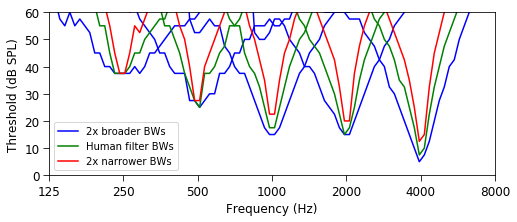

In [67]:
fig, ax = plt.subplots(figsize=(8, 3))

dict_kwargs_plot = {
    'cohc=1.0': {'c': 'k', 'label': 'NH'},
    'cohc=0.0': {'c': 'r', 'label': 'HI'},
    
    'narrow': {'c': 'r', 'label': '2x narrower BWs'},
    'human': {'c': 'g', 'label': 'Human filter BWs'},
    'broad': {'c': 'b', 'label': '2x broader BWs'},
}

for key in sorted(dict_results.keys()):
    for itr0, list_thresholds in enumerate(dict_results[key]):
        if itr0 > 0:
            dict_kwargs_plot[key]['label'] = None
        ax.plot(list_f0, list_thresholds, **dict_kwargs_plot[key])

xticks = [list_cf[0]/2] + list_cf + [list_cf[-1]*2]
ax = util_figures.format_axes(
    ax,
    xscale='log',
    str_xlabel='Frequency (Hz)',
    str_ylabel='Threshold (dB SPL)',
    str_title=None,
    xticks=xticks,
    xticklabels=np.array(xticks).astype(int),
    xticks_minor=[],
    xlimits=[xticks[0], xticks[-1]],
    ylimits=[0, 60])
ax.legend()

plt.show()
